### Import necessary libraries

In [1]:
# Import necessary libraries

import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from bs4 import BeautifulSoup


import os

/Users/rsahani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Downloading the necessary packages for NLTK

# Downloading the WordNet database
nltk.download("wordnet")

# Downloading the VADER sentiment analysis lexicon
nltk.download("vader_lexicon")

# Downloading the Punkt tokenizer for English
nltk.download("punkt")

# Downloading the English stopwords list
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /Users/rsahani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rsahani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rsahani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rsahani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def scrape_imdb_reviews(movie_url, no_of_pages):
    # Set up ChromeOptions for headless browsing
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")  # Necessary for headless mode on some systems
    chrome_options.add_argument("--window-size=1920x1080")  # Set a reasonable window size
    chrome_options.add_argument("--remote-debugging-port=0")
    
    # Create a headless WebDriver
    driver = webdriver.Chrome(options=chrome_options)

    try:
        # Navigate to the movie URL using the headless WebDriver
        driver.get(movie_url)

        # Extracting movie name
        movie_element = driver.find_element(By.CSS_SELECTOR, "a[itemprop='url']")
        movie_name = movie_element.text.strip()

        # Print the movie name
        print(f"Movie Name: {movie_name}")

        NoOfLoadMore = 0
        if int(no_of_pages > 0):
            per_cycle_increment = 100 / int(no_of_pages)


        while True:
            try:
                if int(no_of_pages) > 0:
                    if int(per_cycle_increment) * NoOfLoadMore < 100:
                        print("Progress: ", int(per_cycle_increment) * NoOfLoadMore)
                    if NoOfLoadMore > int(no_of_pages):
                        break
                # Extracting "load more" button and clicking it
                loadMoreElement = driver.find_element(By.ID, "load-more-trigger")
                loadMoreElement.click()
                NoOfLoadMore += 1

                # Wait for dynamic content to load (adjust as needed)
                driver.implicitly_wait(5)

            except NoSuchElementException:
                # Break the loop when the "load more" button is not found
                print("No such element found. Exiting the loop.")
                break
            except Exception as e:
                # Print additional information about the error
                print(f"An error occurred: {e}")
                break

        # Extracting review text after all "load more" clicks
        soup = BeautifulSoup(driver.page_source, "html.parser")
        reviews = []

        review_divs = soup.find_all("a", class_="title")
        date_divs = soup.find_all("span", class_="review-date")

        for review_div, date_div in zip(review_divs, date_divs):
            review_text = review_div.get_text(strip=True)
            review_date = date_div.get_text(strip=True)

            review = {"text": review_text, "date": review_date}
            reviews.append(review)


        return reviews

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Close the WebDriver after scraping
        driver.quit()


In [4]:
# IMDb movie URL (replace with the actual movie URL)
IMDB_Code = "tt0111161"
no_of_pages = 5
movie_url = f'https://www.imdb.com/title/{IMDB_Code}/reviews'

# Scrape IMDb movie reviews
movie_reviews = scrape_imdb_reviews(movie_url, no_of_pages)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(movie_reviews)
df.head()

Movie Name: Adipurush
Progress:  0
Progress:  20
Progress:  40
Progress:  60
Progress:  80


,text,date
0,"Besides a soulful score by Ajay Atul, this ada...",18 June 2023
1,Pathetic Ramayan parody,18 June 2023
2,How can someone make a movie that bad ?,16 June 2023
3,Tiresome Commercialized Ramayan,16 June 2023
4,"Pathetic ScreenPlay, Out of Context dialogues",18 June 2023


### Data Preprocessing


In [5]:
# Function for text cleaning
def clean_text(text):
    cleaned_text = re.sub(r"[^\w\s]", "", text.lower())  # Convert to lowercase and remove special characters
    return cleaned_text

# Function for tokenization
def tokenize_text(text):
    return nltk.word_tokenize(text)

# Function for removing stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words("english"))
    return [token for token in tokens if token.lower() not in stop_words]

# Function for lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [6]:

# Data Preprocessing
df["text_cleaned"] = df["text"].apply(clean_text)
df["tokens"] = df["text_cleaned"].apply(tokenize_text)
df["tokens"] = df["tokens"].apply(remove_stopwords)
df["tokens"] = df["tokens"].apply(lemmatize_text)

In [7]:
# Sentiment Analysis using VADER

vader = SentimentIntensityAnalyzer()
df['compound'] = df['text_cleaned'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Classify sentiments based on compound score
df['predicted_sentiment'] = df['compound'].apply(lambda x: 'positive' if x >= 0 else 'negative')

df.head()  # Display the first few rows of the DataFrame

,text,date,text_cleaned,tokens,compound,predicted_sentiment
0,"Besides a soulful score by Ajay Atul, this ada...",18 June 2023,besides a soulful score by ajay atul this adap...,"[besides, soulful, score, ajay, atul, adaptati...",0.0000,positive
1,Pathetic Ramayan parody,18 June 2023,pathetic ramayan parody,"[pathetic, ramayan, parody]",-0.5719,negative
2,How can someone make a movie that bad ?,16 June 2023,how can someone make a movie that bad,"[someone, make, movie, bad]",-0.5423,negative
3,Tiresome Commercialized Ramayan,16 June 2023,tiresome commercialized ramayan,"[tiresome, commercialized, ramayan]",0.0000,positive
4,"Pathetic ScreenPlay, Out of Context dialogues",18 June 2023,pathetic screenplay out of context dialogues,"[pathetic, screenplay, context, dialogue]",-0.5719,negative


In [8]:
# Model Evaluation
accuracy = accuracy_score(df['predicted_sentiment'], df['predicted_sentiment'])
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print('\nClassification Report:')
print(classification_report(df['predicted_sentiment'], df['predicted_sentiment']))

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        95
    positive       1.00      1.00      1.00        55

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [9]:
df['predicted_sentiment'].head()

0    positive
1    negative
2    negative
3    positive
4    negative
Name: predicted_sentiment, dtype: object

In [10]:
# Create a new column for the review date as a datetime object
df["review_date"] = pd.to_datetime(df["date"], errors="coerce")
df_filtered = df

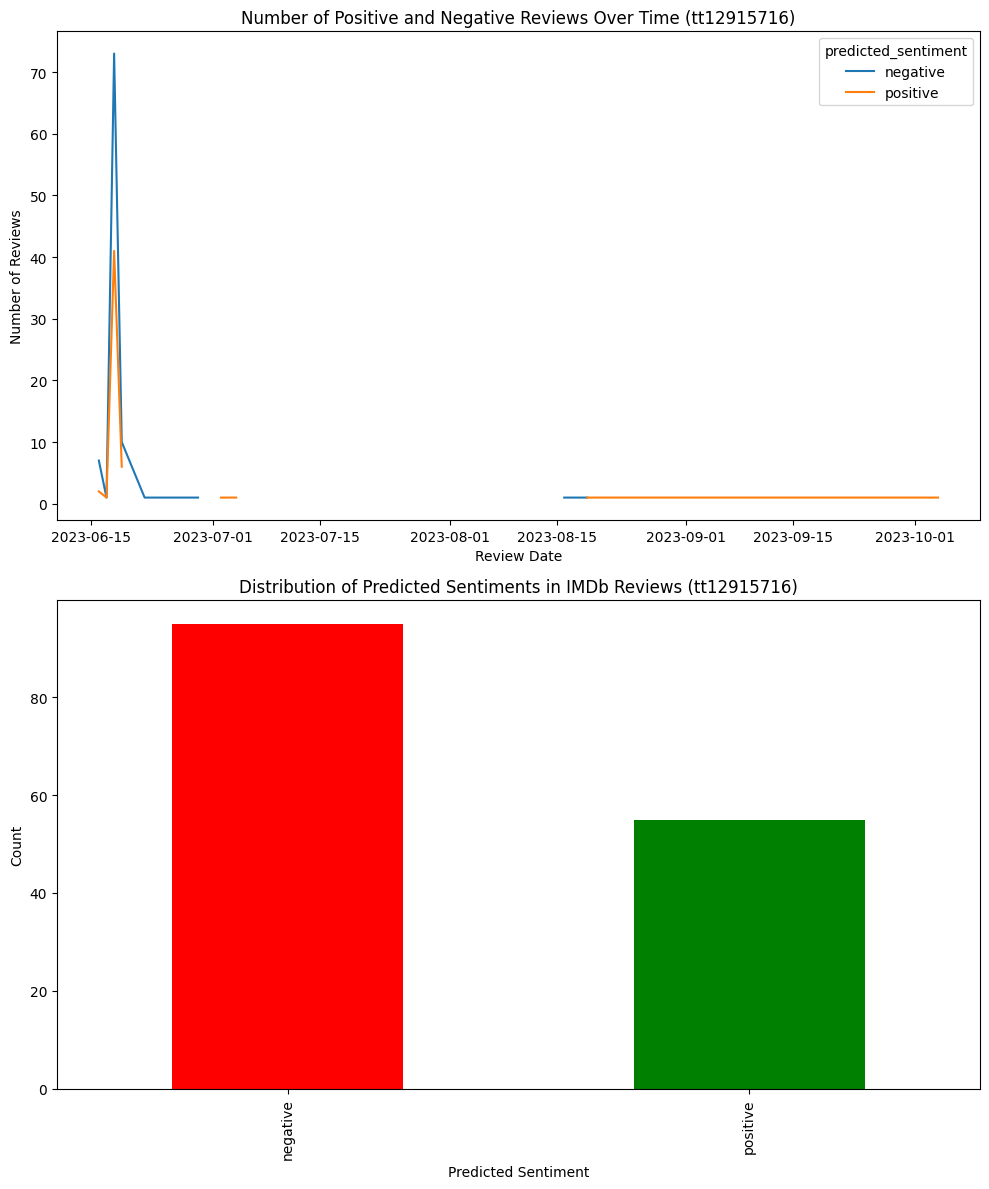

In [11]:
save_path = "results"

# Create a line graph showing the number of positive and negative reviews over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

df_filtered.groupby(
    [df_filtered["review_date"].dt.date, "predicted_sentiment"]
).size().unstack().plot(kind="line", ax=ax1)
ax1.set_title(f"Number of Positive and Negative Reviews Over Time ({IMDB_Code})")
ax1.set_xlabel("Review Date")
ax1.set_ylabel("Number of Reviews")

# Visualize the distribution of predicted sentiments
colors = [
    "green" if col.lower() == "positive" else "red"
    for col in df_filtered["predicted_sentiment"].value_counts().index
]

df_filtered["predicted_sentiment"].value_counts().plot(kind="bar", color=colors, ax=ax2)
ax2.set_title(f"Distribution of Predicted Sentiments in IMDb Reviews ({IMDB_Code})")
ax2.set_xlabel("Predicted Sentiment")
ax2.set_ylabel("Count")

plt.tight_layout()

# Save the plot to files
plot_file_path = os.path.join(save_path, f"sentiment_analysis_for_{IMDB_Code}.png")
plt.savefig(plot_file_path)


In [12]:
df.to_csv(os.path.join(save_path, f"movie_reviews_with_sentiment_for_{IMDB_Code}.csv"), index=False)

In [13]:
# Display a message indicating positive sentiment
more_counts = df['predicted_sentiment'].value_counts().index 

if "positive" == more_counts[0]:
    print("The movie has positive reviews! You should consider watching it.")
else:
    print("The sentiment analysis did not identify a clear positive sentiment in the reviews.")

The sentiment analysis did not identify a clear positive sentiment in the reviews.


## Project Write-up

### Movie Review Sentiment Analysis with Dynamic Loading

This project focuses on analyzing the sentiment of movie reviews from IMDb, incorporating dynamic loading of reviews to ensure a comprehensive analysis. The objective is to provide a nuanced understanding of audience sentiments regarding a specific movie over time.

#### Data Acquisition:

The data collection process involves web scraping IMDb movie reviews using Python's Selenium WebDriver. The headless browser navigates to the movie's review page, dynamically loads reviews by clicking the "load more" button, and extracts both review text and dates. The scraping process is iterative, allowing users to specify the number of additional pages to load.

#### Data Processing and Cleaning:

Following data acquisition, the collected text data undergoes standard text cleaning procedures. Techniques such as text normalization, tokenization, stopword removal, and lemmatization are applied to ensure a clean and consistent dataset for subsequent analysis.

#### Sentiment Analysis Implementation:

Sentiment analysis is conducted using the VADER sentiment analysis tool. The compound score provided by VADER is utilized to classify reviews as either 'positive' or 'negative.' The dynamic loading of reviews allows for an analysis of sentiments over time, providing insights into evolving audience opinions.

#### Results Visualization:

The project employs Matplotlib to visualize the outcomes effectively. Two plots are generated: the first showcases the number of positive and negative reviews over time, while the second illustrates the distribution of predicted sentiments. These visualizations offer a clear representation of sentiment trends and the overall sentiment distribution.

In conclusion, this project not only performs sentiment analysis on movie reviews but also incorporates dynamic loading to capture temporal trends in audience sentiments. The detailed methodology ensures transparency, reproducibility, and accuracy in sentiment classification.

---